In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from lightgbm import LGBMClassifier
from sklearn import datasets
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

In [21]:
### fix the seed
np.random.seed(0)

### simulate the data
X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=2)
bins = 25
train_samples = 100
X_train, y_train = X[:train_samples], y[:train_samples]
X_test, y_test = X[train_samples:], y[train_samples:]


### define keras neural network architecture
def keras_model(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(12, input_dim=20, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


### define the different classifiers
classifiers_1 = {'Logistic Regression': LogisticRegression(),
                 'Naive Bayes': GaussianNB(),
                 'Random Forest': RandomForestClassifier(n_estimators=200, n_jobs=-1),
                 'SVM': LinearSVC()}

classifiers_2 = {'K-NN': KNeighborsClassifier(n_neighbors=13),
                 'LightGBM': LGBMClassifier(),
                 'Multi-layer Perceptron': MLPClassifier(),
                 'Keras Neural Network': KerasClassifier(build_fn=keras_model)}

In [22]:
def fit_classifiers_and_compute_reliability_scores(classifiers, X_train, y_train, X_test, y_test):
    reliability_scores = {}
    y_pred = {}
    y_score = {}
    for clf_name, clf in classifiers.items():
        if isinstance(clf, KerasClassifier):
            clf.fit(x=X_train, y=y_train, batch_size=10, epochs=200, verbose=0, shuffle=True)
            y_pred[clf_name] = clf.predict_proba(X_test)[:, 1]
        elif isinstance(clf, LinearSVC):
            clf.fit(X_train, y_train)
            y_pred[clf_name] = clf.decision_function(X_test)
        else:
            clf.fit(X_train, y_train)
            y_pred[clf_name] = clf.predict_proba(X_test)[:, 1]
        reliability_scores[clf_name] = calibration_curve(y_test, y_pred[clf_name], n_bins=bins, normalize=True)
        y_score[clf_name] = clf.score(X_test, y_test)
        print(clf.__class__.__name__, clf.score(X_test, y_test))
    return reliability_scores, y_pred, y_score

In [23]:
def plot_calibration_curves(reliability_scores, y_pred, y_score):
    plt.figure(0, figsize=(8, 8))   
    plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label='Perfectly calibrated')
    for clf_name, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
        scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
        label = f'{clf_name} ({y_score[clf_name]:1.2f} auc)'
        plt.plot(empirical_prob_pos[scores_not_nan], y_score_bin_mean[scores_not_nan], label=label)
    plt.ylabel('Empirical probability')
    plt.legend(loc=0)
    plt.subplot2grid((3, 1), (2, 0))
    for clf_name, y_score_ in y_pred.items():
        y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
        plt.hist(y_score_, range=(0, 1), bins=bins, label=clf_name, histtype='step', lw=2)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.legend(loc='upper center', ncol=2)
    plt.savefig('calibration_curve_2.png')
    plt.show()

LogisticRegression 0.8448848848848849
GaussianNB 0.8291491491491492
RandomForestClassifier 0.8822222222222222
LinearSVC 0.8385185185185186


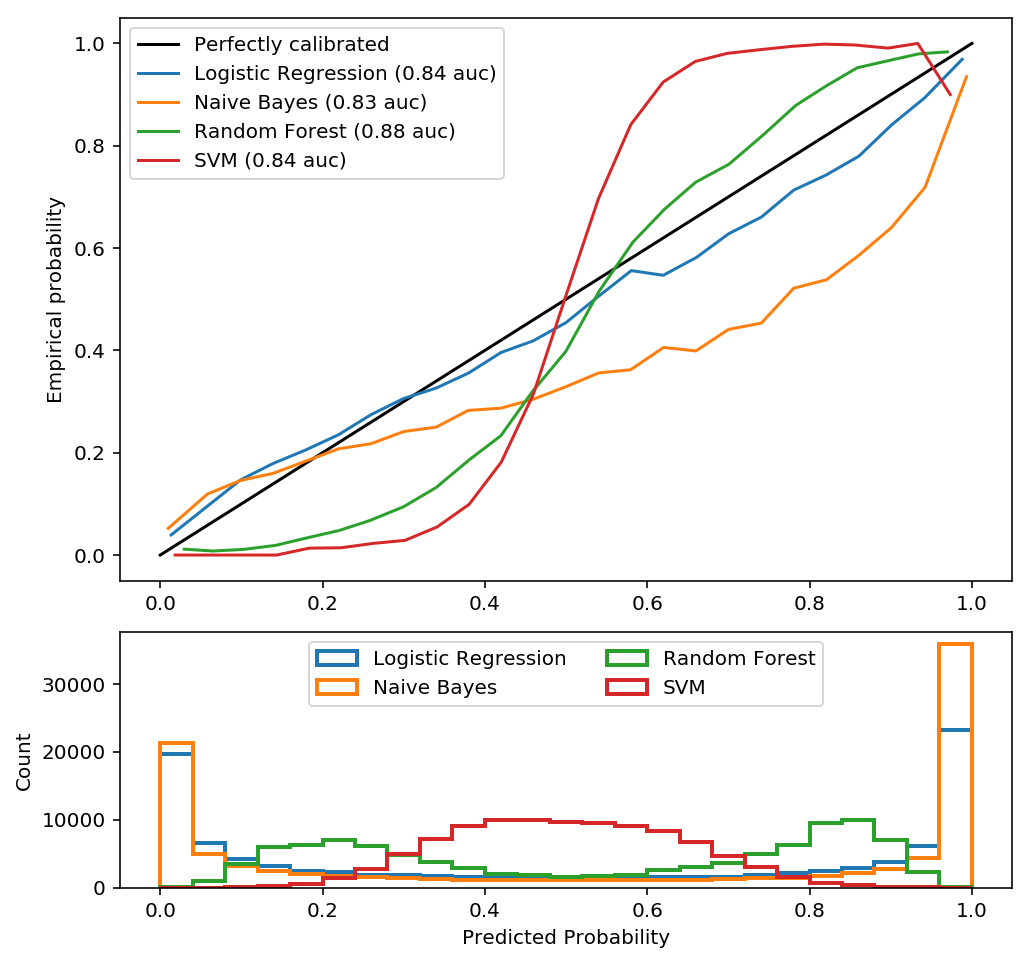

In [24]:
reliability_scores, y_pred, y_score = fit_classifiers_and_compute_reliability_scores(classifiers_1, X_train, y_train, X_test, y_test)
plot_calibration_curves(reliability_scores, y_pred, y_score)

KNeighborsClassifier 0.808928928928929
LGBMClassifier 0.8652552552552553
MLPClassifier 0.8203403403403403
99900/99900 [==============================] - 1s 15us/step
KerasClassifier 0.8199299299275433


/anaconda3/envs/conda_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/conda_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/conda_py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


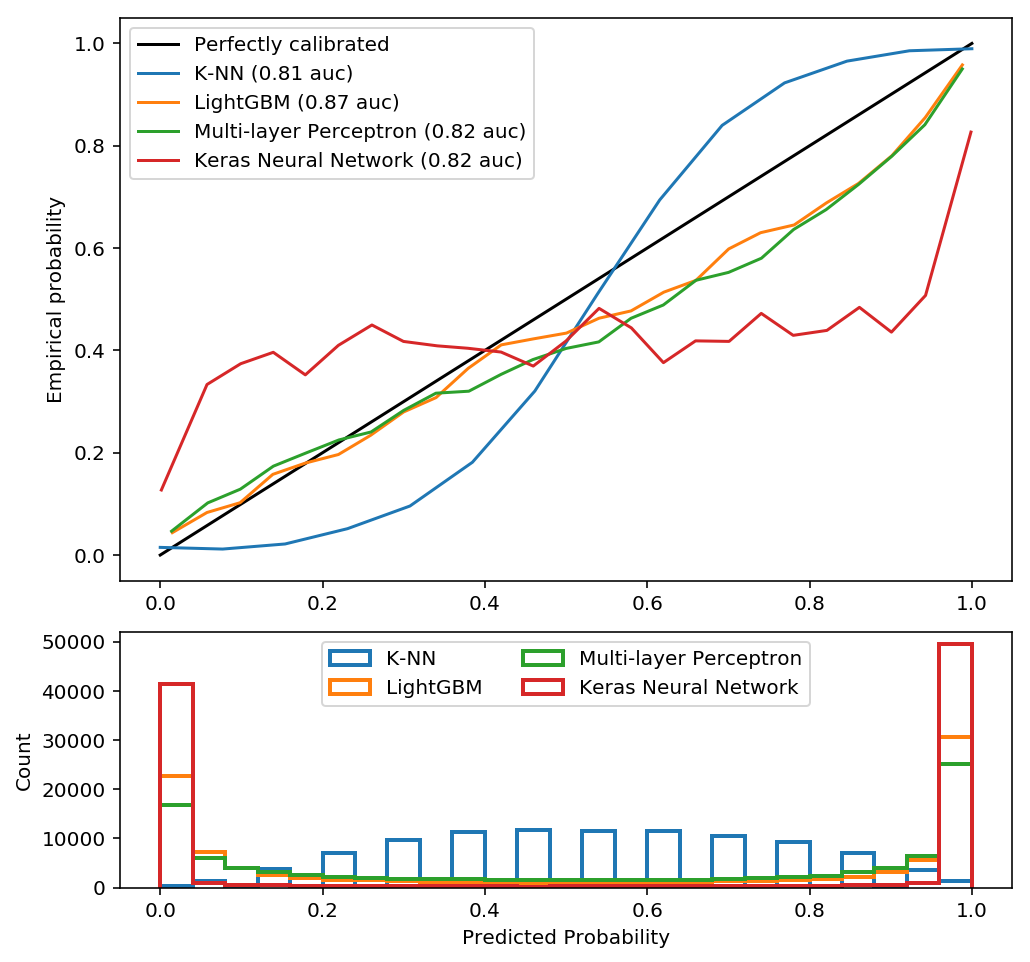

In [25]:
reliability_scores, y_pred, y_score = fit_classifiers_and_compute_reliability_scores(classifiers_2, X_train, y_train, X_test, y_test)
plot_calibration_curves(reliability_scores, y_pred, y_score)
